In [1]:
import pandas as pd
import csv
import numpy as np
import re
import string as string_library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from nltk.stem.porter import PorterStemmer
import math
import warnings
import random
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

# Build the training set and then Classify

In [2]:
# read in the sentences that were already clustered
videos = []
match_ids = {}
with open("sentence_clusters_fastcluster_nonbinary_all.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        if row[0] not in match_ids:
            match_ids[row[0]] = True
        videos.append([row[0], row[1], row[2], row[3], row[4]])
        
videos_en = pd.DataFrame(videos, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum'])
del videos

In [3]:
# add in an isCoupon variable to the dataframe. isCoupon = 1 if the sentence is in our cluster of coupon codes
num_coupon_codes = 0
match_sentences = {}
for i, row in videos_en.iterrows():
    if row['clusterNum'] == str(68):
        num_coupon_codes += 1
        match_sentences[row.sentence] = True
        videos_en.at[i, 'isCoupon'] = 1
    else:
        videos_en.at[i, 'isCoupon'] = 0

In [4]:
print videos_en.shape

(77706, 6)


In [5]:
print num_coupon_codes

177


In [6]:
# There are few coupon codes compared to the size of the dataset
# Need to shrink the negative sample size in our training dataset
# get a random set of 1000 videos from the set
sample_set = videos_en.sample(n=1000)

In [7]:
sample_set.shape

(1000, 6)

In [8]:
# get the sentences that are in the coupon code cluster
positives = []
for i, row in videos_en.iterrows():
    if row['isCoupon'] == 1:
        positives.append([row.id, row.description, row.channelTitle, row.sentence, row.clusterNum, row.isCoupon])
        
positiveDF = pd.DataFrame(positives, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum', 'isCoupon'])
del positives
print(positiveDF.shape)

(177, 6)


In [9]:
# join the set of random values and the set of positives
training_set = sample_set.append(positiveDF, ignore_index=True)
training_set.shape

(1177, 6)

In [10]:
#shuffle the training set
training_set = training_set.sample(frac=1).reset_index(drop=True)

In [11]:
y = training_set.isCoupon

In [12]:
#stemmer = PorterStemmer()

def tokenize(line):
    if (line is None):
        line = ''
    printable = set(string_library.printable)
    line = ''.join(filter(lambda x: x in printable, line)) 
    stopwords = nltk.corpus.stopwords.words('english')

    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]*\'[a-zA-Z]*|\w+')
    
    tokens = []
    
    line = re.sub(r'(http[s]?://|www.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]*|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', line).lower()
    tokens.extend(tokenizer.tokenize(line))
    
    tokens_ = [f.strip(string_library.punctuation) for f in tokens]
    for i in range(len(tokens_)):
        if tokens_[i][0:2] == "b'":
            tokens_[i] = tokens[i][2:]
    tokens_ = [f for f in tokens_ if f != '' and f not in stopwords and len(f) != 1]
    tokens_ = [f for f in tokens_ if not (f.isdigit() or f[0] == '-' and f[1:].isdigit())]
    #tokens_ = [stemmer.stem(f) for f in tokens_]

    return tokens_


In [13]:
# all of the possible parameters to check for
params = {'C': [0.01, 0.1, 0.5, 0.8, 0.9, 1, 1.2, 1.5, 2, 5, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 5, 10, 20, 50]}
clf = GridSearchCV(SVC(probability=True), params, cv=5)

Round 1
Best Params:  {'kernel': 'linear', 'C': 0.5, 'degree': 2}
Best Score:  0.9987244897959183
{'score_time': array([0.00050688, 0.00054002, 0.00056195, 0.00055099, 0.00050497]), 'test_score': array([1., 1., 1., 1., 1.]), 'train_score': array([1., 1., 1., 1., 1.]), 'fit_time': array([5.70196605, 5.7077949 , 5.81953216, 5.72484398, 5.70858097])}
r2 score:  0.9234356781966576
F1 Score:  0.9666666666666666
Confusion matrix: 
[[166   0]
 [  2  29]]


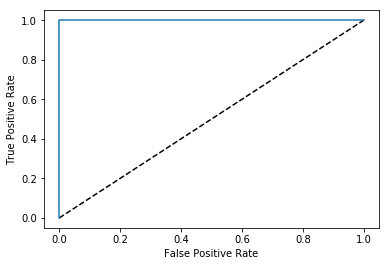

_______________________________________________________________
Round 2
Best Params:  {'kernel': 'linear', 'C': 1.2, 'degree': 2}
Best Score:  1.0
{'score_time': array([0.00052714, 0.0005331 , 0.00055289, 0.00060916, 0.00053191]), 'test_score': array([0.975     , 1.        , 1.        , 1.        , 0.97435897]), 'train_score': array([1.        , 1.        , 1.        , 0.99363057, 0.99363057]), 'fit_time': array([6.16305995, 6.24224401, 6.10856295, 6.10822988, 6.05387402])}
r2 score:  1.0
F1 Score:  1.0
Confusion matrix: 
[[168   0]
 [  0  28]]


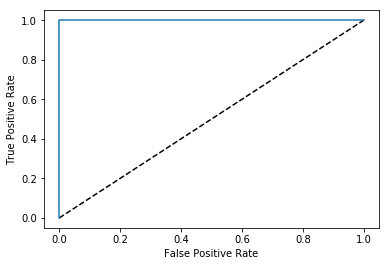

_______________________________________________________________
Round 3
Best Params:  {'kernel': 'linear', 'C': 0.8, 'degree': 2}
Best Score:  0.9974522292993631
{'score_time': array([0.00056601, 0.00051403, 0.00055313, 0.00049996, 0.00051308]), 'test_score': array([0.975     , 1.        , 1.        , 1.        , 0.94871795]), 'train_score': array([1.        , 1.        , 1.        , 1.        , 0.98726115]), 'fit_time': array([6.23473907, 6.01663399, 5.85889387, 6.20603609, 5.69436312])}
r2 score:  1.0
F1 Score:  1.0
Confusion matrix: 
[[172   0]
 [  0  24]]


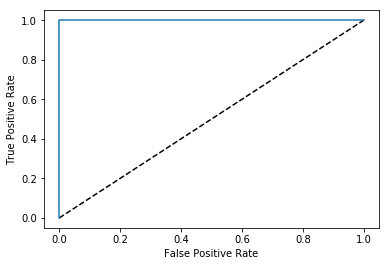

_______________________________________________________________


In [14]:
# run kfold 3 times
kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(training_set)
round_num = 0
for train_index, test_index in kf.split(training_set):
    round_num += 1
    print 'Round', round_num
    #get the training, validating, and testing sets for the sentences
    X_train, X_temp = training_set.loc[train_index], training_set.loc[test_index]
    split_X = np.split(X_temp, [X_temp.shape[0]/2])
    X_validate = split_X[0]
    X_test = split_X[1]
    #get the training, validating, and testing sets for the isCoupon types
    y_train, y_temp = y.loc[train_index], y.loc[test_index]
    split_y = np.split(y_temp, [y_temp.shape[0]/2])
    y_validate = split_y[0]
    y_test = split_y[1]
    
    #Get the word vector from the training set
    countVec = CountVectorizer(tokenizer=tokenize, min_df=3).fit(X_train['sentence'])
    #create the word frequency from the word vector for the training, validating, and testing sets
    lineVec = countVec.transform(X_train['sentence'])
    validateVec = countVec.transform(X_validate['sentence'])
    testVec = countVec.transform(X_test['sentence'])
    
    #fit the classifier
    clf.fit(lineVec, X_train['isCoupon'])
    print "Best Params: ", clf.best_params_
    print "Best Score: ", clf.best_score_
    
    #cross validate
    cv_results = cross_validate(clf, validateVec, y_validate, cv=5, return_train_score=True)
    print cv_results
    
    #test on the test set
    predictions = clf.predict(testVec)
    print 'r2 score: ', metrics.r2_score(y_test, predictions)
    print 'F1 Score: ', metrics.f1_score(y_test, predictions)
    print 'Confusion matrix: '
    print metrics.confusion_matrix(y_test, predictions)
    predicted_probabilites = clf.predict_proba(testVec)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print '_______________________________________________________________'

# Check How the weights will work in the Browser Extension

In [15]:
# build the classifier with the best values found above
classifier = SVC(kernel='linear', C=1, degree=2)
X_temp = np.split(training_set, [training_set.shape[0]/2])
X_train = X_temp[0]
split_X = np.split(X_temp[1], [X_temp[1].shape[0]/2])
X_validate = split_X[0]
X_test = split_X[1]
print X_train.shape
print X_validate.shape
print X_test.shape

(588, 6)
(294, 6)
(295, 6)


In [16]:
#Get the word vectors
countVec = CountVectorizer(tokenizer=tokenize, min_df=3).fit(X_train['sentence'])

In [17]:
#transform sentences into vectors
lineVec = countVec.transform(X_train['sentence'])
validateVec = countVec.transform(X_validate['sentence'])
testVec = countVec.transform(X_test['sentence'])

In [18]:
print lineVec.shape
print validateVec.shape
print testVec.shape

(588, 175)
(294, 175)
(295, 175)


In [19]:
#fit the classifier
classifier.fit(lineVec, X_train['isCoupon'])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [20]:
predictions = classifier.predict(testVec)
print 'r2 score: ', metrics.r2_score(X_test['isCoupon'], predictions)
print 'F1 Score: ', metrics.f1_score(X_test['isCoupon'], predictions)

r2 score:  1.0
F1 Score:  1.0


In [21]:
cross_validate(clf, validateVec, X_validate['isCoupon'], cv=5, return_train_score=True)

{'fit_time': array([7.2837441 , 7.17559791, 7.3439939 , 7.27620792, 7.08459592]),
 'score_time': array([0.00065994, 0.0006659 , 0.00052714, 0.00051713, 0.00061512]),
 'test_score': array([1.        , 0.96610169, 1.        , 0.98305085, 1.        ]),
 'train_score': array([0.99574468, 0.99574468, 0.99574468, 1.        , 1.        ])}

In [22]:
predictions = classifier.predict(testVec)

In [23]:
print 'r2 score: ', metrics.r2_score(X_test['isCoupon'], predictions)
print 'F1 Score: ', metrics.f1_score(X_test['isCoupon'], predictions)

r2 score:  1.0
F1 Score:  1.0


In [24]:
features = countVec.get_feature_names()
weights = classifier.coef_.toarray()[0]
for i in range(len(weights)):
    if weights[i] > 0:
        print "%1.5f" % weights[i], "\t", features[i]

1.86593 	checkout
1.99971 	code
1.00000 	codes
0.50000 	discount
0.13399 	information
0.00000 	music
0.03359 	save
0.13351 	stream
0.13392 	superior
0.01618 	use


In [25]:
features = countVec.get_feature_names()

def get_vector(sentence):
    vector = [0] * len(features)
    tokens = tokenize(sentence)
    for token in tokens:
        if token in features:
            vector[features.index(token)] += 1
    return vector

In [26]:
false_positives = 0
false_negatives = 0
for i, row in videos_en.iterrows():
    tot = 0
    vector = get_vector(row['sentence'])
    for j in range(len(weights)):
        tot += weights[j] * vector[j]
    if tot > 0.5:
        if row['isCoupon'] == 0:
            #print "False +: ", row['sentence']
            false_positives += 1
    else:
        if row['isCoupon'] == 1:
            false_negatives += 1
            #print "False -: ", row['sentence']

In [27]:
total_vids = videos_en.shape[0]
print "Total Inputs: ", total_vids
print "False Positives: ", false_positives # some of these are coupon codes
print "False Positive Percentage: %1.2f" % (false_positives/(total_vids*1.0) * 100), "%"
print "False Negatives: ", false_negatives # could be a result of imperfections in the cluster
print "False Negative Percentage: %1.2f" % (false_negatives/(total_vids*1.0) * 100), "%"

Total Inputs:  77706
False Positives:  123
False Positive Percentage: 0.16 %
False Negatives:  0
False Negative Percentage: 0.00 %


# Export features and Weights

In [28]:
features = countVec.get_feature_names()
non_zero_features = []
print len(features), len(weights)
num_zeroes = 0
weights_string = "const CouponWeights = ["
for i in range(len(weights)):
    item = weights[i]
    if item == 0:
        num_zeroes += 1
    else:
        non_zero_features.append(features[i])
        weights_string += '%1.15f' % item + ", "
weights_string = weights_string[0:-2] + "];"

features_string = "const CouponFeatures = ["
for item in non_zero_features:
    temp = item
    features_string += '"' + temp + '",'
features_string = features_string[0:-1] + "];"

print weights_string
print features_string
print len(non_zero_features), len(weights)-num_zeroes

175 175
const CouponWeights = [-0.000091225325396, -0.000154690952283, -0.044722324741698, -0.004190488434367, -0.000091225325396, -0.044722324741698, 1.865925657523899, 1.999712635243791, 1.000000000000000, -0.004190488434367, -0.100454270569854, 0.500000000000000, -0.000183391354017, -0.000091225325396, -0.000041538248269, -0.000082986726799, -0.015997331310574, -0.067165231081675, -0.000082986726799, -0.000091225325396, 0.133993499419597, -0.033289039488179, -0.133534800800062, -0.016534227402228, -0.004190488434367, 0.000000000000000, -0.118632763901686, -0.000091225325396, -0.067165231081675, -0.004190488434367, -0.044722324741698, 0.033589479820219, -0.000082986726799, -0.500000000000000, -0.000082986726799, 0.133507084780844, 0.133915682228483, -0.032865467396576, -0.000091225325396, 0.016179781961365, -0.033575751261456, -0.000418021836881, -0.000183391354017];
const CouponFeatures = ["additional","also","auto","best","call","car","checkout","code","codes","county","design","di

In [29]:
print "[",
for word in nltk.corpus.stopwords.words('english'):
    print "\"" + word+ "\"", ",",

[ "i" , "me" , "my" , "myself" , "we" , "our" , "ours" , "ourselves" , "you" , "you're" , "you've" , "you'll" , "you'd" , "your" , "yours" , "yourself" , "yourselves" , "he" , "him" , "his" , "himself" , "she" , "she's" , "her" , "hers" , "herself" , "it" , "it's" , "its" , "itself" , "they" , "them" , "their" , "theirs" , "themselves" , "what" , "which" , "who" , "whom" , "this" , "that" , "that'll" , "these" , "those" , "am" , "is" , "are" , "was" , "were" , "be" , "been" , "being" , "have" , "has" , "had" , "having" , "do" , "does" , "did" , "doing" , "a" , "an" , "the" , "and" , "but" , "if" , "or" , "because" , "as" , "until" , "while" , "of" , "at" , "by" , "for" , "with" , "about" , "against" , "between" , "into" , "through" , "during" , "before" , "after" , "above" , "below" , "to" , "from" , "up" , "down" , "in" , "out" , "on" , "off" , "over" , "under" , "again" , "further" , "then" , "once" , "here" , "there" , "when" , "where" , "why" , "how" , "all" , "any" , "both" , "eac

In [30]:
# kf = KFold(n_splits=3, shuffle=True)
# kf.get_n_splits(videos_en_new)
# round_num = 0
# for train_index, test_index in kf.split(videos_en_new):
#     round_num += 1
#     print 'Round', round_num
#     X_train, X_test = videos_en_new.loc[train_index], videos_en_new.loc[test_index]
#     y = videos_en_new.isCoupon
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
#     lineVec = countVec.transform(X_train['sentence'])
#     testVec = countVec.transform(X_test['sentence'])
#     clf.fit(lineVec, X_train['isCoupon'])
#     predictions = clf.predict(testVec)
#     print "Best Params: ", clf.best_params_
#     print "Best Score: ", clf.best_score_
#     #print 'AUC Cross-validated scores:', cross_val_score(clf, lineVec, y_train, cv=5, scoring='roc_auc')
#     print 'r2 score: ', metrics.r2_score(y_test, predictions)
#     print 'F1 Score: ', metrics.f1_score(y_test, predictions)
#     print 'Confusion matrix: '
#     print metrics.confusion_matrix(y_test, predictions)
#     predicted_probabilites = clf.predict_proba(testVec)[:,1]
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.plot(fpr, tpr, label='Logistic Regression')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()
#     print '_______________________________________________________________'